In [ ]:
import os
import numpy as np
import torch

from src.resnet import ResNet18
from src.pca import PCATransformer
from src.draw_figures import *
from src.dataloader import CIFARCustom

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
os.makedirs("./data", exist_ok=True) 
os.makedirs("./models", exist_ok=True) 
os.makedirs("./figures", exist_ok=True) 

### 1. Подготовка данных:

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

target = 3

train_dataset = CIFARCustom(
    root="./data",
    exclude_class=[target],
    train=True, 
    transform=transform
)

train_size = int(0.8 * len(train_dataset))
val_size = int(0.15 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train, val, test = random_split(train_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test, batch_size=64, shuffle=False, num_workers=2)


target_dataset = CIFARCustom(
    root="./data",
    exclude_class=[i for i in range(10) if i != target],
    train=True, 
    transform=transform
)

target_train_size = int(0.85 * len(target_dataset))
target_val_size = len(target_dataset) - target_train_size

train_target, val_target = random_split(target_dataset, [target_train_size, target_val_size])

train_target_loader = DataLoader(train_target, batch_size=64, shuffle=True, num_workers=2)
val_target_loader = DataLoader(val_target, batch_size=64, shuffle=True, num_workers=2)

In [3]:

len(train_dataset), len(target_dataset), len(train), len(val), len(test), len(train_target), len(val_target)

(45000, 5000, 36000, 6750, 2250, 4250, 750)

### 2. Обучение и inference модели на тестовой наборе данных

In [4]:
resnet = ResNet18(
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        learning_rate=0.001,
        num_epochs=10,
        weights="./models/resnet18_cifar10_without3.pth"
    )

# history = resnet.train()

Loaded weights from ./models/resnet18_cifar10_without3.pth


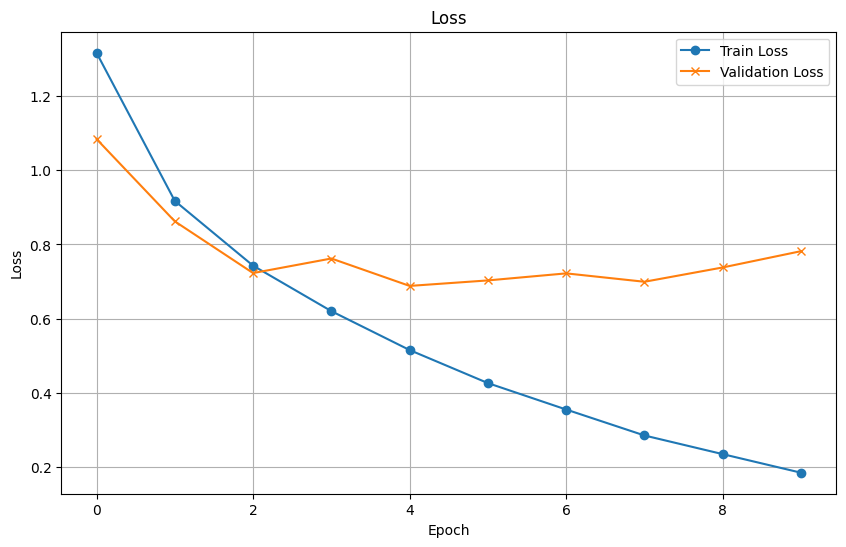

In [ ]:
# plot_loss(history['train_loss'], history['val_loss'])

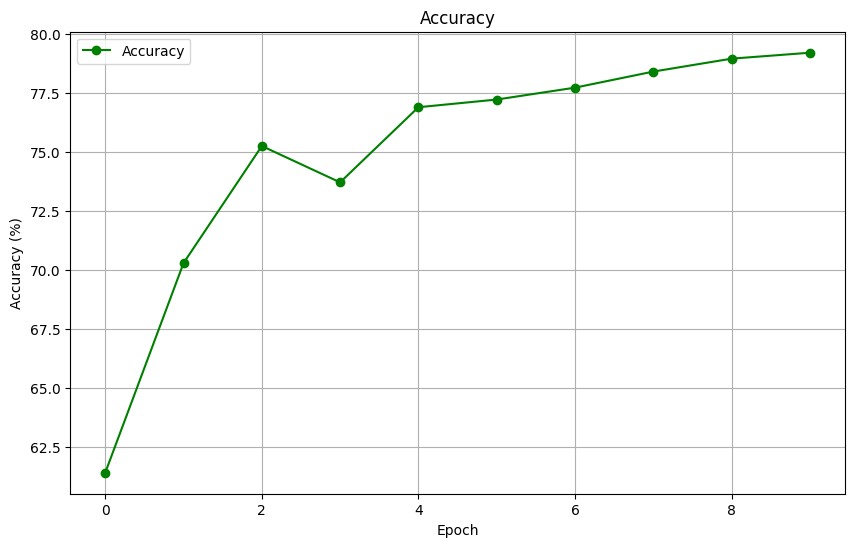

In [ ]:
# plot_accuracy(history['val_accuracy'])

In [ ]:
# resnet.save_model('./models/resnet18_cifar10_without3.pth')

Model saved to ./models/resnet18_cifar10_without3.pth


### 3. Извлечение признаков модели, построение pca пространства, проецирование данных 

#### Тестовая выборка

In [5]:
features, labels, correct_preds = resnet.extract_features(test_loader)

CR = features[correct_preds == 1]  
WR = features[correct_preds == 0] 


len(CR), len(WR)

(2093, 157)

Финальное количество главных компонент: 20
Объяснённая дисперсия: 0.95


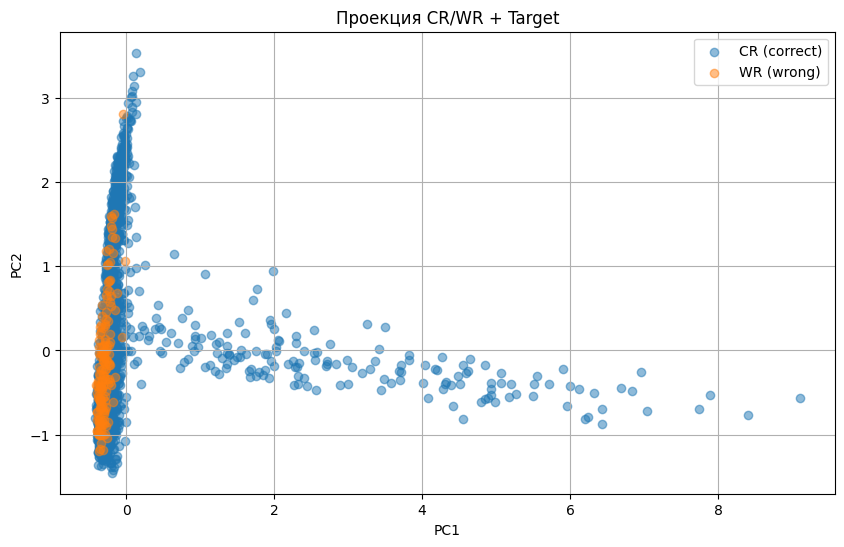

In [6]:
all_train = np.vstack((CR, WR))
pca = PCATransformer(whiten=True) 
pca.fit(all_train)


CR_p = pca.transform(CR)
WR_p = pca.transform(WR)

                            
plot_pca_projection(CR_p, WR_p)

#### Target выборка

In [7]:
features_target_train, labels_target_train, correct_preds_target_train = resnet.extract_features(train_target_loader)

CR_train_target = features_target_train[correct_preds_target_train == 1]  
WR_train_target = features_target_train[correct_preds_target_train == 0] 

len(CR_train_target), len(WR_train_target)

(0, 4250)

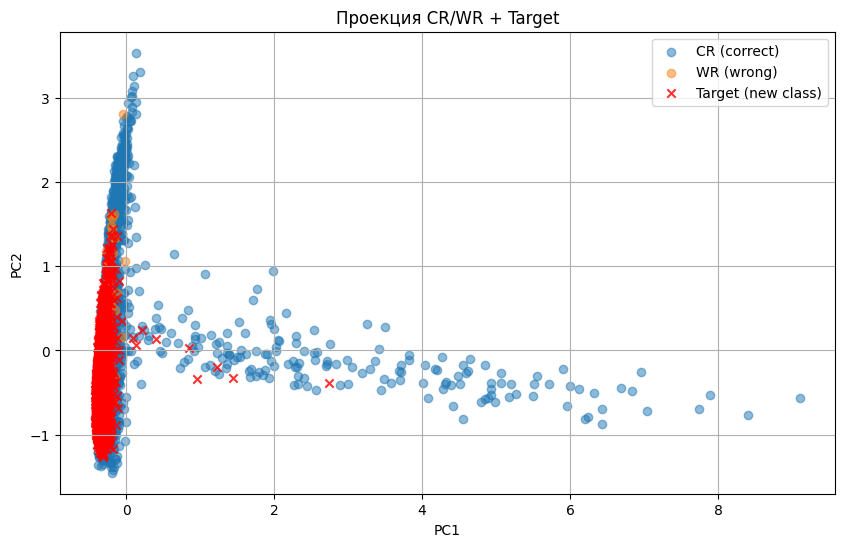

In [8]:
train_target_p = pca.transform(features_target_train)
plot_pca_projection(CR_p, WR_p, target_data=train_target_p)

#### 4. (Исключительно вариант курсовой) Обучние lda target vs cr + wr

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


X = np.vstack((CR_p, WR_p, train_target_p))

# 0 = старые классы (CR+WR), 1 = новый unseen класс
y = np.hstack((
    np.zeros(len(CR_p) + len(WR_p)),
    np.ones(len(train_target_p))
))

In [26]:
lda = LinearDiscriminantAnalysis(n_components=1)  # для двух классов максимум 1 компонента
X_lda = lda.fit_transform(X, y)

print("Shape после LDA:", X_lda.shape)

Shape после LDA: (6500, 1)


In [9]:
features_target_val, labels_target_val, correct_preds_target_val = resnet.extract_features(val_target_loader)

CR_val_target = features_target_val[correct_preds_target_val == 1]  
WR_val_target = features_target_val [correct_preds_target_val == 0] 

len(CR_val_target), len(WR_val_target)

(0, 750)

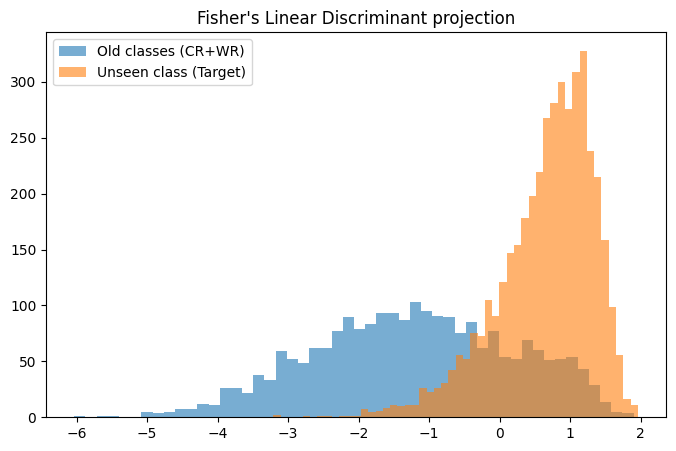

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(X_lda[y==0], bins=50, alpha=0.6, label="Old classes (CR+WR)")
plt.hist(X_lda[y==1], bins=50, alpha=0.6, label="Unseen class (Target)")
plt.legend()
plt.title("Fisher's Linear Discriminant projection")
plt.show()


#### На будущее

In [21]:
from sklearn.cluster import KMeans

def cluster(X, num_clusters=10, debug=True):

    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    if debug:
        counts = np.bincount(labels)
        print("Размеры кластеров WR:", counts)

    return labels, kmeans

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def train_fisher_discriminant(train_CR_p, train_WR_p, wr_labels):

    X = np.vstack([train_CR_p, train_WR_p])
    y = np.hstack([np.zeros(len(train_CR_p)), wr_labels + 1]) 
    # CR = 0, WR кластеры = 1..k

    lda = LinearDiscriminantAnalysis(solver="svd")  
    lda.fit(X, y)

    return lda

In [23]:
def evaluate_fisher(lda, test_CR_p, test_WR_p):

    X_test = np.vstack([test_CR_p, test_WR_p])
    y_test = np.hstack([np.zeros(len(test_CR_p)), np.ones(len(test_WR_p))])  # 0=CR, 1=WR

    y_pred = lda.predict(X_test)
    acc = np.mean(y_pred == y_test)

    print(f"Accuracy Fisher discriminant: {acc:.2%}")
    return y_pred, y_test

In [24]:
import pandas as pd

X = np.vstack((CR_p, WR_p, target_p)) # Уточнить момент вот этот 
labels, kmeans = cluster(X, num_clusters=10)

cluster_ids = labels
groups = (["CR"] * len(CR_p)) + (["WR"] * len(WR_p)) + (["TARGET"] * len(target_p))

df = pd.DataFrame({"cluster": cluster_ids, "group": groups})
table = pd.crosstab(df["cluster"], df["group"])
print(table)

NameError: name 'target_p' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Берём только первые 2 PCA-компоненты
X2d = np.vstack((CR_p[:,:10], WR_p[:,:10], target_p[:,:10]))

# Кластеризация в 2D
kmeans2d = KMeans(n_clusters=10, random_state=42, n_init=10)
labels2d = kmeans2d.fit_predict(X2d)

import pandas as pd

cluster_ids = labels2d
groups = (["CR"] * len(CR_p[:,:10])) + (["WR"] * len(WR_p[:,:10])) + (["TARGET"] * len(target_p[:,:10]))

df = pd.DataFrame({"cluster": cluster_ids, "group": groups})
table = pd.crosstab(df["cluster"], df["group"])
print(table)

group     CR  TARGET   WR
cluster                  
0        143    1640  149
1        175     163   58
2        166     507   71
3        190     347   16
4        174      75    9
5        170     225   43
6        171     610   75
7        131    1426   35
8        359       7   37
9         76       0    2


In [ ]:
import pandas as pd

cluster_ids = labels2d
groups = (["CR"] * len(CR_p[:,:2])) + (["WR"] * len(WR_p[:,:2])) + (["TARGET"] * len(target_p[:,:2]))

df = pd.DataFrame({"cluster": cluster_ids, "group": groups})
table = pd.crosstab(df["cluster"], df["group"])
print(table)

group     CR  TARGET   WR
cluster                  
0        143    1640  149
1        175     163   58
2        166     507   71
3        190     347   16
4        174      75    9
5        170     225   43
6        171     610   75
7        131    1426   35
8        359       7   37
9         76       0    2


In [ ]:
# 1. Кластеризация WR
labels, kmeans = cluster(np.vstack((CR_p, WR_p, target_p)), num_clusters=10)

# # 2. Дискриминант Фишера
# lda = train_fisher_discriminant(train_CR_p, train_WR_p, wr_labels)

# # 3. Оценка на тесте
# y_pred, y_test = evaluate_fisher(lda, test_CR_p, test_WR_p)

Размеры кластеров WR: [ 664 1214  669  937  623  898  723  230  901  391]


In [ ]:
# all_train = np.vstack((train_CR, train_WR))
# pca = PCATransformer(n_components='auto', whiten=True) 
# pca.fit(all_train)


# train_CR_pca = pca.transform(train_CR)
# train_WR_pca = pca.transform(train_WR)
# test_CR_pca = pca.transform(test_CR)
# test_WR_pca = pca.transform(test_WR)

# draw_pca_projection(train_CR_pca, train_WR_pca)